# Install

In [ ]:
pip install -q pingouin scikit-bio cliffs_delta

# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova
import cliffs_delta
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input

In [ ]:
df_raw = pd.read_excel('../data/Survey_Data.xlsx', sheet_name='raw_check', skiprows=1, header=0)
df = pd.read_excel('../data/Survey_Data.xlsx', sheet_name='convert')

In [95]:
df_raw

,Model,Student,B1,BT1,B2,BT2,B3,BT3,B4,BT4,...,C7,C8,C9,C10,C11,C12,C13,Check_3,C14,C15
0,Base,B1,1,50.155,1,29.583,1,79.572,1,20.340,...,4,5,1,4,3,2,3,3,4,3
1,Base,B2,1,72.249,1,81.811,1,126.767,1,21.286,...,5,3,3,5,3,2,2,3,3,1
2,Base,B3,1,90.234,1,91.759,1,74.163,0,66.995,...,5,4,3,3,3,2,3,3,3,2
3,Base,B4,1,84.163,1,51.351,1,67.535,0,66.328,...,4,3,1,1,1,5,4,3,2,1
4,Base,B5,1,128.336,1,157.507,1,71.867,1,75.599,...,5,5,5,5,4,4,4,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Enhanced,E42,1,71.594,1,12.291,1,53.294,1,159.871,...,5,3,4,5,2,1,2,3,4,2
89,Enhanced,E43,1,112.058,1,27.546,1,114.798,1,111.843,...,4,4,3,4,3,2,4,3,3,3
90,Enhanced,E44,1,85.929,1,52.547,1,22.815,0,140.295,...,5,3,4,4,3,2,3,3,2,1
91,Enhanced,E45,1,47.269,1,64.176,1,83.564,1,94.059,...,4,3,3,4,3,3,4,3,3,3


In [96]:
df

,Model,Student,Accuracy,Time,Confidence,PC,EF,CF,CE,CL,DS,UI,VA
0,Base,B1,100,20.93528,4,4.000000,5,4,4,1,4,1,3
1,Base,B2,100,25.15960,3,3.666667,4,4,5,3,5,3,5
2,Base,B3,80,11.54480,4,2.333333,2,2,5,2,3,3,3
3,Base,B4,80,7.40560,2,2.000000,1,1,4,3,1,1,2
4,Base,B5,100,32.48024,4,5.000000,5,5,5,1,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Enhanced,E42,100,50.03168,4,3.333333,4,4,5,3,5,4,3
89,Enhanced,E43,100,39.98984,4,3.000000,3,3,4,2,4,3,4
90,Enhanced,E44,80,38.10304,3,4.333333,5,4,5,3,4,4,4
91,Enhanced,E45,100,14.64120,3,4.000000,4,3,4,3,4,3,3


# Variables

In [97]:
metrics = ["Accuracy", "Time", "Confidence", "PC", "EF", "CF", "CE", "CL", "DS", "UI", "VA"]
objective_vars = ["Accuracy", "Time"]
likert_vars = ["Confidence", "PC", "EF", "CF", "CE", "CL", "DS", "UI", "VA"]

# Outputs

## Data Collected

### Mean & SD

In [98]:
results = []

for m in objective_vars:
    base = df[df["Model"] == "Base"][m]
    enh = df[df["Model"] == "Enhanced"][m]

    base_mean = base.mean()
    base_std = base.std()
    enh_mean = enh.mean()
    enh_std = enh.std()

    results.append({
        "Metric": m,
        "Baseline (Mean ± SD)": f"{base_mean:.3f} ± {base_std:.3f}",
        "Enhanced (Mean ± SD)": f"{enh_mean:.3f} ± {enh_std:.3f}"
    })

summary_mean_df = pd.DataFrame(results)
summary_mean_df

,Metric,Baseline (Mean ± SD),Enhanced (Mean ± SD)
0,Accuracy,74.894 ± 21.455,89.130 ± 11.705
1,Time,42.090 ± 24.496,29.847 ± 12.910


### Median & IQR

In [99]:
def hl_and_ci(base, enh, alpha=0.05):
    base = np.array(base)
    enh = np.array(enh)

    diffs = enh.reshape(-1, 1) - base.reshape(1, -1)
    diffs = diffs.flatten()

    hl = np.median(diffs)
    ci_low = np.quantile(diffs, alpha/2)
    ci_high = np.quantile(diffs, 1 - alpha/2)

    return hl, ci_low, ci_high

results = []

for m in metrics:
    base = df[df["Model"] == "Base"][m].values
    enh = df[df["Model"] == "Enhanced"][m].values

    base_median = np.median(base)
    enh_median = np.median(enh)
    base_iqr = np.percentile(base, 75) - np.percentile(base, 25)
    enh_iqr = np.percentile(enh, 75) - np.percentile(enh, 25)

    hl, ci_low, ci_high = hl_and_ci(base, enh)

    results.append({
        "Metric": m,
        "Baseline (Median, IQR)": f"{base_median:.3f}, IQR={base_iqr:.3f}",
        "Enhanced (Median, IQR)": f"{enh_median:.3f}, IQR={enh_iqr:.3f}",
        "HL median diff": f"{hl:.3f}",
        "HL CI low": f"{ci_low:.3f}",
        "HL CI high": f"{ci_high:.3f}",
        "N (per group)": f"{len(base)} / {len(enh)}"
    })

summary_df = pd.DataFrame(results)
summary_df

,Metric,"Baseline (Median, IQR)","Enhanced (Median, IQR)",HL median diff,HL CI low,HL CI high,N (per group)
0,Accuracy,"80.000, IQR=30.000","90.000, IQR=20.000",20.000,-20.000,60.000,47 / 46
1,Time,"34.596, IQR=34.367","27.870, IQR=16.394",-8.484,-76.466,34.135,47 / 46
2,Confidence,"3.000, IQR=1.000","4.000, IQR=1.000",1.000,-1.000,2.000,47 / 46
3,PC,"3.333, IQR=1.667","3.667, IQR=1.000",0.333,-2.000,2.333,47 / 46
4,EF,"3.000, IQR=3.000","4.000, IQR=2.000",1.000,-2.000,4.000,47 / 46
5,CF,"3.000, IQR=2.000","4.000, IQR=0.000",1.000,-1.000,3.000,47 / 46
6,CE,"5.000, IQR=1.000","5.000, IQR=1.000",0.000,-2.000,4.000,47 / 46
7,CL,"3.000, IQR=1.000","2.000, IQR=1.000",0.000,-2.000,2.000,47 / 46
8,DS,"3.000, IQR=2.000","4.000, IQR=1.000",1.000,-2.000,4.000,47 / 46
9,UI,"3.000, IQR=3.000","4.000, IQR=2.000",1.000,-2.000,4.000,47 / 46


### Median & IQR Visualization

In [100]:
for m in metrics:
    base = df[df["Model"] == "Base"][m]
    enh = df[df["Model"] == "Enhanced"][m]

    base_median = base.median()
    enh_median = enh.median()

    base_q1 = base.quantile(0.25)
    base_q3 = base.quantile(0.75)
    enh_q1 = enh.quantile(0.25)
    enh_q3 = enh.quantile(0.75)

    base_iqr = base_q3 - base_q1
    enh_iqr = enh_q3 - enh_q1

    results.append({
        "Metric": m,
        "Model": "Base",
        "Median": base_median,
        "IQR": base_iqr
    })
    results.append({
        "Metric": m,
        "Model": "Enhanced",
        "Median": enh_median,
        "IQR": enh_iqr
    })

summary_df = pd.DataFrame(results)

In [101]:
df_main = summary_df[summary_df["Metric"].isin(objective_vars)]
df_likert = summary_df[summary_df["Metric"].isin(likert_vars)]

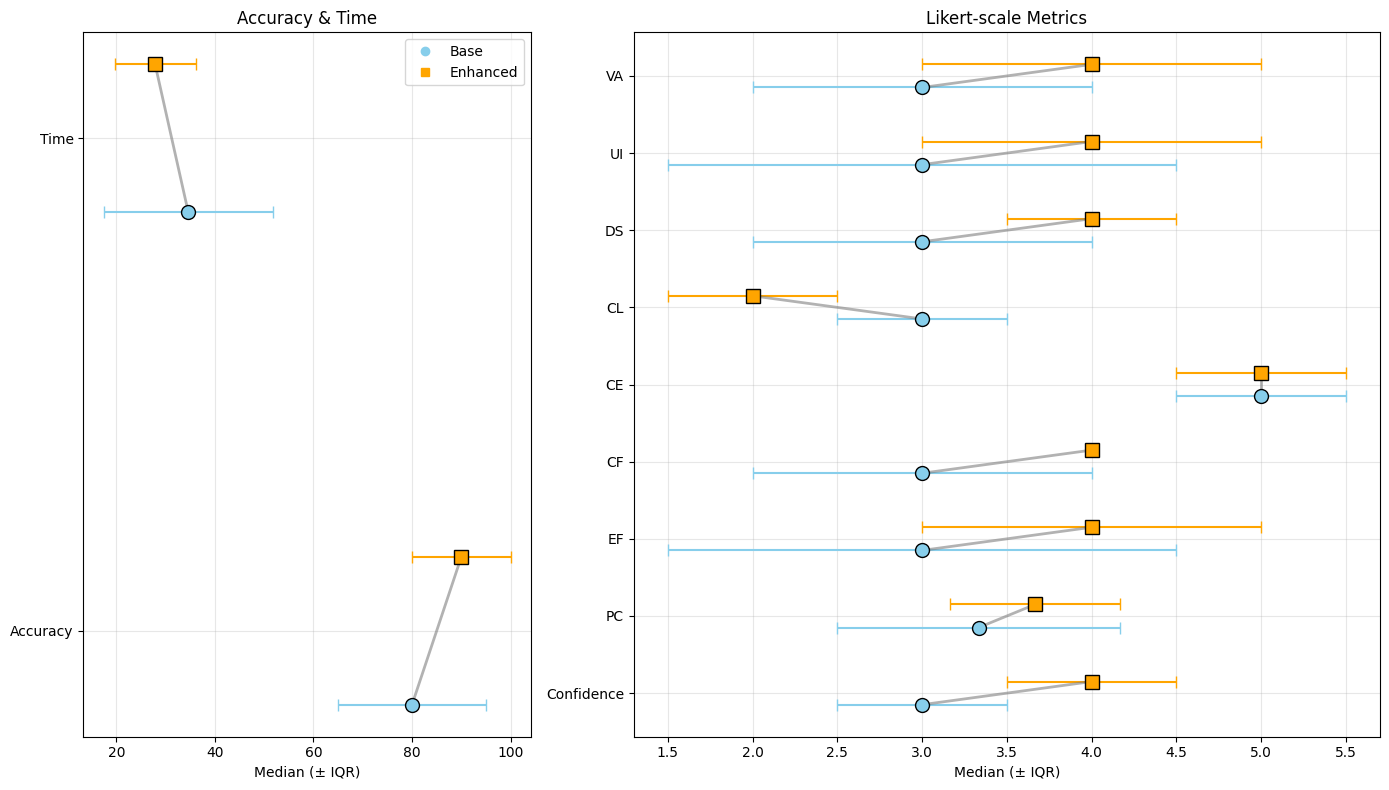

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios':[1.2, 2]})

# Accuracy + Time
ax = axes[0]
y_positions = np.arange(len(objective_vars))

for i, metric in enumerate(objective_vars):
    base = df_main[(df_main["Metric"] == metric) & (df_main["Model"] == "Base")]
    enh  = df_main[(df_main["Metric"] == metric) & (df_main["Model"] == "Enhanced")]

    # Base plot (shift y - 0.15)
    ax.errorbar(
        base["Median"], i - 0.15,
        xerr=base["IQR"] / 2,
        fmt="o", markersize=10,
        color="skyblue", ecolor="skyblue", capsize=4,
        markeredgecolor="black"
    )

    # Enhanced plot (shift y + 0.15)
    ax.errorbar(
        enh["Median"], i + 0.15,
        xerr=enh["IQR"] / 2,
        fmt="s", markersize=10,
        color="orange", ecolor="orange", capsize=4,
        markeredgecolor="black"
    )

    # Line connecting Base ↔ Enhanced
    ax.plot([base["Median"].values[0], enh["Median"].values[0]],
            [i - 0.15, i + 0.15],
            color="gray", linewidth=2, alpha=0.6)

ax.set_yticks(y_positions)
ax.set_yticklabels(objective_vars)
ax.set_xlabel("Median (± IQR)")
ax.set_title("Accuracy & Time")
ax.grid(alpha=0.3)

# Legend
ax.plot([], [], "o", color="skyblue", label="Base")
ax.plot([], [], "s", color="orange", label="Enhanced")
ax.legend()


# 9 Likert Variables
ax = axes[1]
likert = list(df_likert["Metric"].unique())
y_positions = np.arange(len(likert))

for i, metric in enumerate(likert):
    base = df_likert[(df_likert["Metric"] == metric) & (df_likert["Model"] == "Base")]
    enh  = df_likert[(df_likert["Metric"] == metric) & (df_likert["Model"] == "Enhanced")]

    # Base (y - 0.15)
    ax.errorbar(
        base["Median"], i - 0.15,
        xerr=base["IQR"] / 2,
        fmt="o", markersize=10,
        color="skyblue", ecolor="skyblue", capsize=4,
        markeredgecolor="black"
    )

    # Enhanced (y + 0.15)
    ax.errorbar(
        enh["Median"], i + 0.15,
        xerr=enh["IQR"] / 2,
        fmt="s", markersize=10,
        color="orange", ecolor="orange", capsize=4,
        markeredgecolor="black"
    )

    # connecting line
    ax.plot([base["Median"].values[0], enh["Median"].values[0]],
            [i - 0.15, i + 0.15],
            color="gray", linewidth=2, alpha=0.6)

ax.set_yticks(y_positions)
ax.set_yticklabels(likert)
ax.set_xlabel("Median (± IQR)")
ax.set_title("Likert-scale Metrics")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Reliability testing

In [103]:
scales = {
    "PC": ["C1", "C3", "C6"]
}

def compute_scale_reliability(df, scales):
    results = []
    for scale_name, items in scales.items():
        missing_cols = [col for col in items if col not in df.columns]
        if missing_cols:
            print(f"Warning: scale {scale_name} missing columns: {missing_cols}")
            continue

        data_scale = df[items].dropna()
        n_items = len(items)

        alpha, ci = pg.cronbach_alpha(data=data_scale)

        scale_score = data_scale.sum(axis=1)
        mean_score = scale_score.mean()
        sd_score = scale_score.std()
        results.append({
            "Scale": scale_name,
            "N_items": n_items,
            "Cronbach_alpha": round(alpha,3),
            "CI_lower": round(ci[0],3),
            "CI_upper": round(ci[1],3),
            "Mean_score": round(mean_score,3),
            "SD_score": round(sd_score,3),
            "N_obs": data_scale.shape[0]
        })
    return pd.DataFrame(results)

reliability_df = compute_scale_reliability(df_raw, scales)
reliability_df

,Scale,N_items,Cronbach_alpha,CI_lower,CI_upper,Mean_score,SD_score,N_obs
0,PC,3,0.764,0.667,0.837,10.151,2.524,93


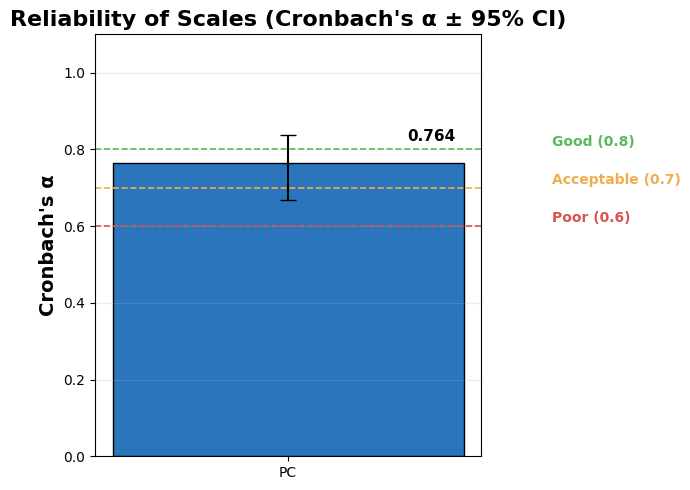

In [104]:
df_plot = reliability_df.copy()

plt.figure(figsize=(7,5))

bars = plt.bar(df_plot['Scale'], df_plot['Cronbach_alpha'],
        yerr=[df_plot['Cronbach_alpha'] - df_plot['CI_lower'],
              df_plot['CI_upper'] - df_plot['Cronbach_alpha']],
        capsize=6, color='#2a75bb', edgecolor='black')

for bar, alpha in zip(bars, df_plot['Cronbach_alpha']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/1.1, height + 0.05, f"{alpha:.3f}",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

for thresh, label, color in zip([0.6, 0.7, 0.8], ['Poor', 'Acceptable', 'Good'], ['#d9534f','#f0ad4e','#5cb85c']):
    plt.axhline(thresh, color=color, linestyle='--', linewidth=1.2)
    plt.text(len(df_plot)-0.4, thresh + 0.01, f"{label} ({thresh})", color=color, fontsize=10, fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel("Cronbach's α", fontsize=14, fontweight='bold')
plt.title("Reliability of Scales (Cronbach's α ± 95% CI)", fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


## PERMANOVA

In [105]:

X = df[metrics].values
groups = df['Model'].values

dist = pdist(X, metric='euclidean')
dist_matrix = DistanceMatrix(squareform(dist))

result = permanova(dist_matrix, groups, permutations=999)
result

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,93
number of groups,2
test statistic,11.96206
p-value,0.001
number of permutations,999


## Mann-Whitney U and Cliff’s Delta

In [106]:
def cliffs_delta_ci(x, y, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    boot_vals = []

    x = np.array(x)
    y = np.array(y)

    for _ in range(n_boot):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        delta_b, _ = cliffs_delta.cliffs_delta(xb, yb)
        boot_vals.append(delta_b)

    lower = np.percentile(boot_vals, 2.5)
    upper = np.percentile(boot_vals, 97.5)

    return lower, upper, boot_vals

In [107]:
results = []

for v in metrics:
    base = df[df["Model"]=="Base"][v].astype(float)
    enhanced = df[df["Model"]=="Enhanced"][v].astype(float)

    stat, p = mannwhitneyu(base, enhanced, alternative='two-sided')

    delta, size = cliffs_delta.cliffs_delta(base, enhanced)

    ci_low, ci_high, _ = cliffs_delta_ci(base, enhanced)

    results.append({
        "Variables": v,
        "p-value": f"{p:.5f}",
        "Cliff's δ": f"{delta:.3f}",
        "95% CI": f"{ci_low:.3f}, {ci_high:.3f}"
    })

mann_df = pd.DataFrame(results)
mann_df

,Variables,p-value,Cliff's δ,95% CI
0,Accuracy,0.00069,-0.379,"-0.565, -0.182"
1,Time,0.02010,0.280,"0.051, 0.500"
2,Confidence,0.00033,-0.398,"-0.587, -0.203"
3,PC,0.05027,-0.234,"-0.450, 0.004"
4,EF,0.00320,-0.341,"-0.544, -0.125"
5,CF,0.00030,-0.402,"-0.588, -0.200"
6,CE,0.34202,-0.102,"-0.296, 0.105"
7,CL,0.07327,0.205,"-0.014, 0.425"
8,DS,0.00013,-0.442,"-0.633, -0.233"
9,UI,0.00004,-0.483,"-0.673, -0.285"


In [108]:
results = []

for v in metrics:
    base = df[df["Model"]=="Base"][v]
    enhanced = df[df["Model"]=="Enhanced"][v]

    stat, p = mannwhitneyu(base, enhanced, alternative='two-sided')
    delta, size = cliffs_delta.cliffs_delta(base, enhanced)

    direction = "Enhanced > Base" if delta < 0 else "Base > Enhanced"

    results.append([v, p, delta, size, direction])

df_stats = pd.DataFrame(results, columns=["Variable", "p", "delta", "size", "direction"])
df_stats

,Variable,p,delta,size,direction
0,Accuracy,0.000690,-0.379278,medium,Enhanced > Base
1,Time,0.020100,0.280296,small,Base > Enhanced
2,Confidence,0.000331,-0.398242,medium,Enhanced > Base
3,PC,0.050268,-0.234043,small,Enhanced > Base
4,EF,0.003195,-0.340888,medium,Enhanced > Base
5,CF,0.000299,-0.401943,medium,Enhanced > Base
6,CE,0.342020,-0.101758,negligible,Enhanced > Base
7,CL,0.073270,0.204903,small,Base > Enhanced
8,DS,0.000130,-0.441721,medium,Enhanced > Base
9,UI,0.000039,-0.482886,large,Enhanced > Base


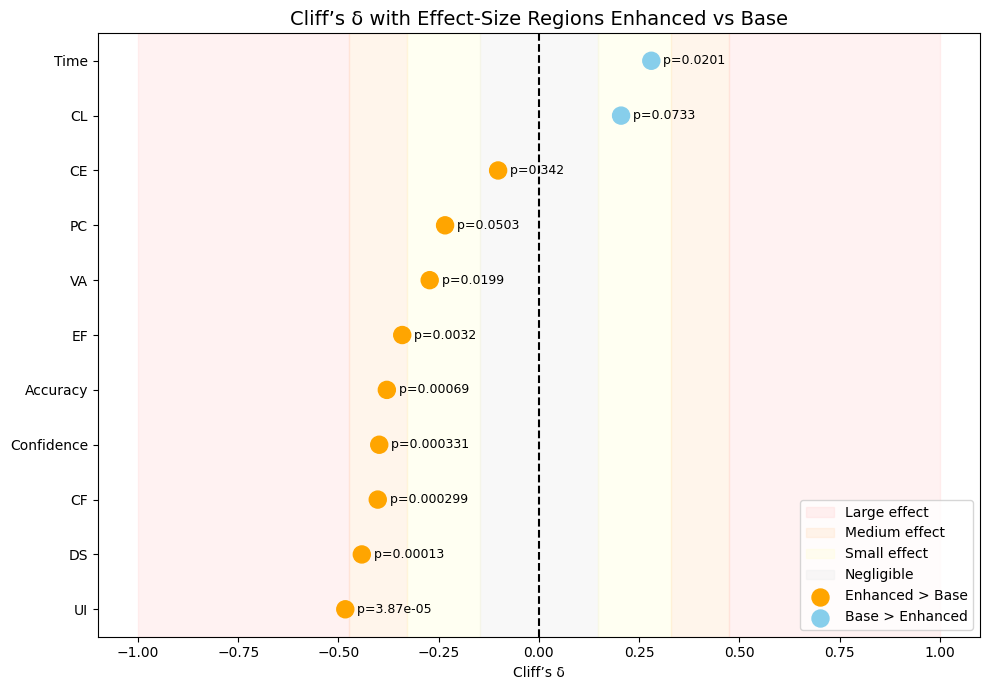

In [109]:
# Sort
df_stats_sorted = df_stats.sort_values("delta")

plt.figure(figsize=(10, 7))

y = np.arange(len(df_stats_sorted))

# Colors by direction
colors = df_stats_sorted["delta"].apply(
    lambda d: "orange" if d < 0 else "skyblue"
)

# --- Add shaded effect-size regions on x-axis ---
plt.axvspan(-1, -0.474, color="#ffcccc", alpha=0.25, label="Large effect")
plt.axvspan(-0.474, -0.33, color="#ffd9b3", alpha=0.25, label="Medium effect")
plt.axvspan(-0.33, -0.147, color="#ffffcc", alpha=0.25, label="Small effect")
plt.axvspan(-0.147, 0.147, color="#e6e6e6", alpha=0.25, label="Negligible")

plt.axvspan(0.147, 0.33, color="#ffffcc", alpha=0.25)
plt.axvspan(0.33, 0.474, color="#ffd9b3", alpha=0.25)
plt.axvspan(0.474, 1, color="#ffcccc", alpha=0.25)

# --- Main points ---
plt.scatter(
    df_stats_sorted["delta"],
    y,
    c=colors,
    s=150,
    edgecolor=colors
)

# Add p-value labels
for i, (_, row) in enumerate(df_stats_sorted.iterrows()):
    plt.text(row["delta"], i, f"   p={row['p']:.3g}", va="center", fontsize=9)

# Zero line
plt.axvline(0, color="black", linestyle="--")

# Labels
plt.yticks(y, df_stats_sorted["Variable"])
plt.xlabel("Cliff’s δ")
plt.title("Cliff’s δ with Effect-Size Regions Enhanced vs Base", fontsize=14)

# Direction legend
plt.scatter([], [], color="orange", s=150, edgecolor="orange", label="Enhanced > Base")
plt.scatter([], [], color="skyblue", s=150, edgecolor="skyblue", label="Base > Enhanced")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [110]:
groups

array(['Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base',
       'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base',
       'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base',
       'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base',
       'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base',
       'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Base', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced', 'Enhanced',
       'Enhanced', 'Enhanced', 'En

## PCA

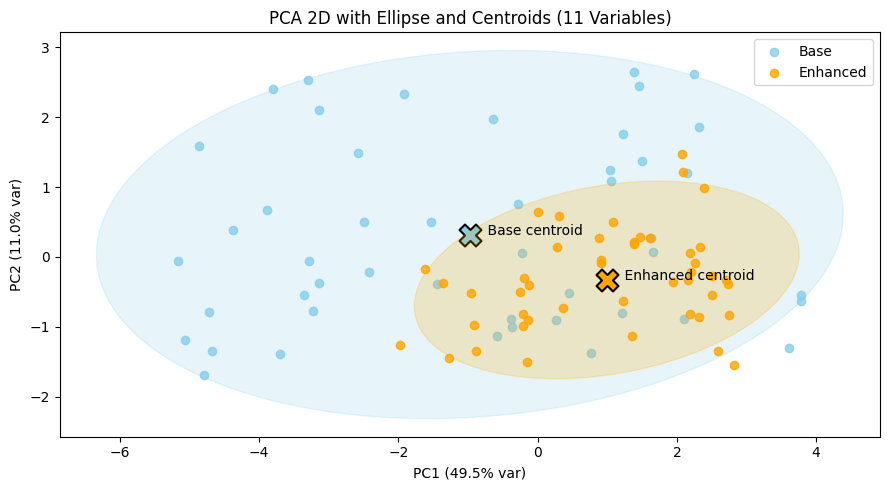

In [111]:
def plot_confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = x.mean()
    mean_y = y.mean()

    transf = (plt.matplotlib.transforms.Affine2D()
              .rotate_deg(45)
              .scale(scale_x, scale_y)
              .translate(mean_x, mean_y))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


X = df[metrics].values
groups = df['Model'].values   # Base / Enhanced

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df["PC1"] = components[:, 0]
df["PC2"] = components[:, 1]

# Centroid
centroids = df.groupby("Model")[["PC1", "PC2"]].mean()


fig, ax = plt.subplots(figsize=(9,5))

colors = {'Base': 'skyblue', 'Enhanced': 'orange'}

for label in df['Model'].unique():
    subset = df[df['Model'] == label]

    # Scatter
    ax.scatter(subset.PC1, subset.PC2,
               label=label,
               color=colors[label],
               alpha=0.8)

    # Ellipse
    plot_confidence_ellipse(subset.PC1.values,
                            subset.PC2.values,
                            ax,
                            n_std=2,
                            facecolor=colors[label],
                            alpha=0.2,
                            edgecolor=colors[label])

    # Centroid
    cx, cy = centroids.loc[label]
    ax.scatter(cx, cy, s=250, marker='X', color=colors[label], edgecolor='black', linewidth=1.5)
    ax.text(cx, cy, f"    {label} centroid", fontsize=10)


ax.set_title("PCA 2D with Ellipse and Centroids (11 Variables)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.legend()
plt.tight_layout()
plt.show()